# EDA for Gas Fees - V2

In this notebook we perform Exploratory Data Analysis (EDA) on FIL's gas fee mechanism. The goal is to observe the gas fee as a signal and attempt to understand what may be driving it. 


### Questions to be answered in this notebook:
* Understand data we have by performing a data baseline - event and aggregated data.
* Reverse engineer June 3 spike - what happened and why? Can we generalize what drives burning?
* Distribution of attributes of things people are willing to pay gas fees for. What types of transactions are individuals paying more for?
* Reperform Granger Causality when we have more data understanding

### Potential steps:
* Are revenues over cost?
* Obtain message metadata, try and predict cost from it (classifier or regressor). Which attributes are mapped to smaller or larger costs? Which messages are worth paying a lot for? The question is what people are they paying for and *why*?

### Change log:

## Background information: What are Gas Fees? 
Note: this description is copied from the [official Filecoin documentation](https://docs.filecoin.io/about-filecoin/how-filecoin-works/#gas-fees)

Executing messages, for example by including transactions or proofs in the chain, consumes both computation and storage resources on the network. Gas is a measure of resources consumed by messages. The gas consumed by a message directly affects the cost that the sender has to pay for it to be included in a new block by a miner.

Historically in other blockchains, miners specify a GasFee in a unit of native currency and then pay the block producing miners a priority fee based on how much gas is consumed by the message. Filecoin works similarly, except an amount of the fees is burned (sent to an irrecoverable address) to compensate for the network expenditure of resources, since all nodes need to validate the messages. The idea is based on Ethereum's EIP1559.

The amount of fees burned in the Filecoin network comes given by a dynamic BaseFee which gets automatically adjusted according to the network congestion parameters (block sizes). The current value can be obtained from one of the block explorers or by inspecting the current head.

Additionally, a number of gas-related parameters are attached to each message and determine the amount of rewards that miners get. Here's an overview of the terms and concepts:

**GasUsage**: the amount of gas that a message's execution actually consumes. Current protocol does not know how much gas a message will exactly consume ahead of execution, but it can be estimated (see prices (opens new window)). GasUsage measured in units of Gas.

**BaseFee**: the amount of FIL that gets burned per unit of gas consumed for the execution of every message. It is measured in units of attoFIL/Gas.

**GasLimit**: the limit on the amount of gas that a message's execution can consume, estimated and specified by a message sender. It is measured in units of Gas. The sum of GasLimit for all messages included in a block must not exceed the BlockGasLimit. Messages will fail to execute if they run out of Gas, and any effects of the execution will be reverted.

**GasFeeCap**: the maximum token amount that a sender is willing to pay per GasUnit for including a message in a block. It is measured in units of attoFIL/Gas. A message sender must have a minimum balance of GasFeeCap * GasLimit when sending a message, even though not all of that will be consumed. GasFeeCap can serve as a safeguard against high, unexpected BaseFee fluctuations.

**GasPremium**: a priority fee that is paid to the block-producing miner. This is capped by GasFeeCap. The BaseFee has a higher priority. It is measured in units of attoFIL/Gas and can be as low as 1 attoFIL/Gas.

**Overestimation burn**: an additional amount of gas to burn that grows larger when the difference between GasLimit and GasUsage is large. 

The total cost of a message for a sender will be:

* GasUsage * BaseFee FIL (burned) +
* GasLimit * GasPremium FIL (miner's reward) +
* OverEstimationBurn * BaseFee FIL

An important detail is that a message will always pay the burn fee, regardless of the GasFeeCap used. Thus, a low GasFeeCap may result in a reduced GasPremium or even a negative one! In that case, the miners that include a message will have to pay the needed amounts out of their own pockets, which means they are unlikely to include such messages in new blocks.

Filecoin implementations may choose the heuristics of how their miners select messages for inclusion in new blocks, but they will usually attempt to maximize the miner's rewards.


## Data Resources
* https://hackmd.io/5leND7tITX--5NJsFCJyow # Existing Sentinel queries 
* https://github.com/filecoin-project/sentinel/blob/master/docs/sentinel_tables_purpose.csv # Sentinel Tables Purpose


### Sentinel Diagram 
![](sentinel_diagram.png)

In [1]:
# import libraries
from sqlalchemy import create_engine
import pandas as pd
from datetime import datetime
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import seaborn as sns


from Cryptoeconomics_signal_processing import time_analysis, fourier_transform, phase_shift_overlay

%matplotlib inline

In [2]:
# load connection string
CONN_STRING_PATH = '../config/sentinel_conn_string_andrew.txt'


with open(CONN_STRING_PATH, 'r') as fid:
    conn_string = fid.read()
    
# create database connection.
connection = create_engine(conn_string, pool_recycle=3600).connect()


## Data EDA

Below we download hourly averages from the `messages` and `mesage_gas_economy` table from May 1st, 2021 to present (last refreshed 6/28/2021). After downloading the data, we few the first and lasts 5 rows, and perform basic statistics on the data.


### Data Dictionary - coped from [Sentinel's Data Dictionary](https://github.com/filecoin-project/sentinel/blob/master/docs/db.md)

### `derived_gas_outputs` 
Derived gas costs resulting from execution of a message in the VM.

|Name|Type|Nullable|Description|
|---|---|---|---|
|`actor_name`|`text`|NO|Human readable identifier for the type of the actor.|
|`base_fee_burn`|`text`|NO|The amount of FIL (in attoFIL) to burn as a result of the base fee. It is parent_base_fee (or gas_fee_cap if smaller) multiplied by gas_used. Note: successfull window PoSt messages are not charged this burn.|
|`cid`|`text`|NO|CID of the message.|
|`exit_code`|`bigint`|NO|The exit code that was returned as a result of executing the message. Exit code 0 indicates success. Codes 0-15 are reserved for use by the runtime. Codes 16-31 are common codes shared by different actors. Codes 32+ are actor specific.|
|`from`|`text`|NO|Address of actor that sent the message.|
|`gas_burned`|`bigint`|NO|The overestimated units of gas to burn. It is a portion of the difference between gas_limit and gas_used.|
|`gas_fee_cap`|`text`|NO|The maximum price that the message sender is willing to pay per unit of gas.|
|`gas_limit`|`bigint`|YES|A hard limit on the amount of gas (i.e., number of units of gas) that a message’s execution should be allowed to consume on chain. It is measured in units of gas.|
|`gas_premium`|`text`|NO|The price per unit of gas (measured in attoFIL/gas) that the message sender is willing to pay (on top of the BaseFee) to "tip" the miner that will include this message in a block.|
|`gas_refund`|`bigint`|NO|The overestimated units of gas to refund. It is a portion of the difference between gas_limit and gas_used.|
|`gas_used`|`bigint`|NO|A measure of the amount of resources (or units of gas) consumed, in order to execute a message.|
|`height`|`bigint`|NO|Epoch this message was executed at.|
|`method`|`bigint`|YES|The method number to invoke. Only unique to the actor the method is being invoked on. A method number of 0 is a plain token transfer - no method exectution.|
|`miner_penalty`|`text`|NO|Any penalty fees (in attoFIL) the miner incured while executing the message.|
|`miner_tip`|`text`|NO|The amount of FIL (in attoFIL) the miner receives for executing the message. Typically it is gas_premium * gas_limit but may be lower if the total fees exceed the gas_fee_cap.|
|`nonce`|`bigint`|YES|The message nonce, which protects against duplicate messages and multiple messages with the same values.|
|`over_estimation_burn`|`text`|NO|The fee to pay (in attoFIL) for overestimating the gas used to execute a message. The overestimated gas to burn (gas_burned) is a portion of the difference between gas_limit and gas_used. The over_estimation_burn value is gas_burned * parent_base_fee.|
|`parent_base_fee`|`text`|NO|The set price per unit of gas (measured in attoFIL/gas unit) to be burned (sent to an unrecoverable address) for every message execution.|
|`refund`|`text`|NO|The amount of FIL (in attoFIL) to refund to the message sender after base fee, miner tip and overestimation amounts have been deducted.|
|`size_bytes`|`bigint`|YES|Size in bytes of the serialized message.|
|`state_root`|`text`|NO|CID of the parent state root.|
|`to`|`text`|NO|Address of actor that received the message.|
|`value`|`text`|NO|The FIL value transferred (attoFIL) to the message receiver.|



## `message_gas_economy`
Gas economics for all messages in all blocks at each epoch.

|Name|Type|Nullable|Description|
|---|---|---|---|
|`base_fee`|`double precision`|NO|The set price per unit of gas (measured in attoFIL/gas unit) to be burned (sent to an unrecoverable address) for every message execution.|
|`base_fee_change_log`|`double precision`|NO|The logarithm of the change between new and old base fee.|
|`gas_capacity_ratio`|`double precision`|YES|The gas_limit_unique_total / target gas limit total for all blocks.|
|`gas_fill_ratio`|`double precision`|YES|The gas_limit_total / target gas limit total for all blocks.|
|`gas_limit_total`|`bigint`|NO|The sum of all the gas limits.|
|`gas_limit_unique_total`|`bigint`|YES|The sum of all the gas limits of unique messages.|
|`gas_waste_ratio`|`double precision`|YES|(gas_limit_total - gas_limit_unique_total) / target gas limit total for all blocks.|
|`height`|`bigint`|NO|Epoch these economics apply to.|
|`state_root`|`text`|NO|CID of the parent state root at this epoch.|


## `messages`
Validated on-chain messages by their CID and their metadata.

|Name|Type|Nullable|Description|
|---|---|---|---|
|`cid`|`text`|NO|CID of the message.|
|`from`|`text`|NO|Address of the actor that sent the message.|
|`gas_fee_cap`|`text`|NO|The maximum price that the message sender is willing to pay per unit of gas.|
|`gas_limit`|`bigint`|NO|-|
|`gas_premium`|`text`|NO|The price per unit of gas (measured in attoFIL/gas) that the message sender is willing to pay (on top of the BaseFee) to "tip" the miner that will include this message in a block.|
|`height`|`bigint`|NO|Epoch this message was executed at.|
|`method`|`bigint`|YES|The method number invoked on the recipient actor. Only unique to the actor the method is being invoked on. A method number of 0 is a plain token transfer - no method exectution.|
|`nonce`|`bigint`|NO|The message nonce, which protects against duplicate messages and multiple messages with the same values.|
|`size_bytes`|`bigint`|NO|Size of the serialized message in bytes.|
|`to`|`text`|NO|Address of the actor that received the message.|
|`value`|`text`|NO|Amount of FIL (in attoFIL) transferred by this message.|


We will focus on analyzing the methods by actor type using the derived gas outputs table. The data is very large, so we will perform individul SQL queries in order to obtain all of the required data.

In [3]:
# # message level data
QUERY = """
SELECT  
to_timestamp(height_to_unix(d.height)) AS timestamp,
d.actor_name,
d.base_fee_burn,
d.cid,
d.exit_code,
d.from,
d.gas_burned,
d.gas_fee_cap,
d.gas_limit,
d.gas_premium,
d.gas_refund,
d.gas_used,
d.height,
d.method,
d.miner_penalty,
d.miner_tip,
d.nonce,
d.over_estimation_burn,
d.parent_base_fee,
d.refund,
d.size_bytes,
d.state_root,
d.to,
d.value
FROM derived_gas_outputs d
WHERE
to_timestamp(height_to_unix(d.height)) BETWEEN '2021-06-01' AND '2021-06-02'
"""
derived_gas_outputs_message_level = (pd.read_sql(QUERY, connection))

For June 1 and June 2, what are the number of transactions by actor type?

In [6]:
derived_gas_outputs_message_level.actor_name.value_counts()

fil/4/storageminer      1481249
fil/4/account             30867
fil/4/storagemarket        2468
fil/4/multisig             1447
<unknown>                   106
fil/4/storagepower          105
fil/4/paymentchannel         13
Name: actor_name, dtype: int64

In [7]:
# # message level data
QUERY = """
SELECT DISTINCT
d.actor_name,
d.method
FROM derived_gas_outputs d
WHERE
to_timestamp(height_to_unix(d.height)) BETWEEN '2021-06-01' AND '2021-06-30'
GROUP BY
d.actor_name,
d.method
"""
derived_gas_outputs_message_level_actors = (pd.read_sql(QUERY, connection))



Count of all actor types and methods used during June.

In [8]:
derived_gas_outputs_message_level_actors

,actor_name,method
0,fil/4/account,0
1,fil/4/account,2
2,fil/4/account,3
3,fil/4/account,5
4,fil/4/init,2
5,fil/4/multisig,0
6,fil/4/multisig,2
7,fil/4/multisig,3
8,fil/4/paymentchannel,0
9,fil/4/storagemarket,2


In [9]:
# # message level data
QUERY = """
SELECT 
d.base_fee_burn,
d.exit_code,
d.gas_burned,
d.gas_fee_cap,
d.gas_limit,
d.gas_premium,
d.gas_refund,
d.gas_used,
d.height,
d.method,
d.miner_penalty,
d.miner_tip,
d.nonce,
d.over_estimation_burn,
d.parent_base_fee,
d.refund
FROM derived_gas_outputs d
WHERE
to_timestamp(height_to_unix(d.height)) BETWEEN '2021-06-01' AND '2021-06-30'
AND d.actor_name = 'fil/4/storagemarket'
"""

derived_gas_outputs_message_level_storage_market = (pd.read_sql(QUERY, connection))


In [10]:
derived_gas_outputs_message_level_storage_market.describe()

,base_fee_burn,exit_code,gas_burned,gas_fee_cap,gas_limit,gas_premium,gas_refund,gas_used,height,method,miner_penalty,miner_tip,nonce,over_estimation_burn,parent_base_fee,refund
count,6.162100e+04,61621.000000,6.162100e+04,6.162100e+04,6.162100e+04,6.162100e+04,6.162100e+04,6.162100e+04,61621.000000,61621.000000,6.162100e+04,6.162100e+04,6.162100e+04,6.162100e+04,6.162100e+04,6.162100e+04
mean,4.077972e+16,0.010029,3.149639e+06,4.907266e+09,9.461527e+07,5.401222e+05,1.593134e+07,7.553429e+07,846308.565603,2.701660,3.712199e+10,5.211299e+13,4.294501e+04,1.772818e+15,5.151027e+08,3.931660e+17
std,8.308884e+16,0.407687,3.708446e+07,5.702000e+09,1.364981e+08,3.220969e+07,2.230157e+07,1.049736e+08,23904.654520,0.954238,8.437992e+12,5.624881e+15,1.095876e+05,3.217716e+16,5.082366e+08,6.334691e+17
min,1.060004e+09,0.000000,0.000000e+00,9.923600e+04,4.990251e+06,9.785700e+04,0.000000e+00,3.164190e+05,806640.000000,2.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+02,0.000000e+00
25%,1.610871e+15,0.000000,3.749990e+05,8.400163e+08,1.342555e+07,9.990800e+04,2.248854e+06,1.080154e+07,825870.000000,2.000000,0.000000e+00,1.354255e+12,1.164900e+04,5.657481e+13,8.416376e+07,1.751587e+16
50%,7.358929e+15,0.000000,3.800620e+05,4.844441e+09,1.359130e+07,1.004860e+05,2.277422e+06,1.093414e+07,844469.000000,2.000000,0.000000e+00,3.530529e+12,3.041800e+04,2.530612e+14,4.118912e+08,7.686502e+16
75%,2.545670e+16,0.000000,4.481954e+06,6.277822e+09,1.513857e+08,2.040790e+05,2.570593e+07,1.189982e+08,866511.000000,4.000000,0.000000e+00,2.670426e+13,3.466600e+04,8.453336e+14,8.856992e+08,2.828606e+17
max,1.505270e+18,19.000000,8.749464e+09,1.898583e+11,9.021040e+09,5.032031e+09,1.244673e+08,5.589476e+08,890160.000000,4.000000,2.084783e+15,1.358518e+18,2.454082e+06,7.594399e+18,6.273926e+09,6.907386e+18


In [11]:
# derived_gas_outputs_message_level_storage_market.plot(x='height',y='gas_used',c='method',kind='scatter')

Text(0.5, 1.0, 'Distributions of Storage Market Gased used by method')

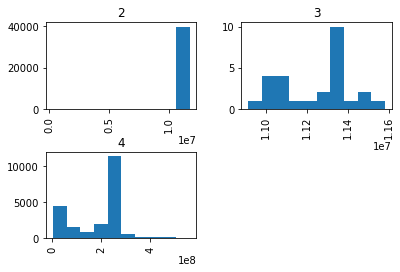

In [12]:
derived_gas_outputs_message_level_storage_market.hist(column='gas_used',by='method')
plt.title('Distributions of Storage Market Gased used by method')

In [13]:
QUERY = """
SELECT 
to_timestamp(height_to_unix(g.height)) as timestamp,
g.base_fee,
g.base_fee_change_log,
g.gas_capacity_ratio,
g.gas_fill_ratio,
g.gas_limit_total,
g.gas_limit_unique_total,
g.gas_waste_ratio
FROM message_gas_economy g
WHERE
to_timestamp(height_to_unix(g.height)) BETWEEN '2021-06-02' AND '2021-06-05'
ORDER BY
timestamp ASC
"""
message_gas_economy = (pd.read_sql(QUERY, connection))

In [14]:
# Use state root and parent state root to combine, height if not available

In [15]:
message_gas_economy.head()

,timestamp,base_fee,base_fee_change_log,gas_capacity_ratio,gas_fill_ratio,gas_limit_total,gas_limit_unique_total,gas_waste_ratio
0,2021-06-02 00:00:00+00:00,2.600000e-16,-0.257298,0.764315,1.998053,5.994159e+10,2.292944e+10,1.233738
1,2021-06-02 00:00:30+00:00,2.490000e-16,-0.367020,0.678527,1.988991,5.966973e+10,2.035580e+10,1.310464
2,2021-06-02 00:01:00+00:00,2.520000e-16,0.101680,1.113587,1.999106,3.998213e+10,2.227174e+10,0.885519
3,2021-06-02 00:01:30+00:00,2.630000e-16,0.362743,1.351031,1.999886,2.999829e+10,2.026547e+10,0.648855
4,2021-06-02 00:02:00+00:00,2.540000e-16,-0.295626,0.739098,1.995247,6.983364e+10,2.586842e+10,1.256149


In [16]:
QUERY = """
SELECT 
to_timestamp(height_to_unix(m.height)) as timestamp,
m.from,
m.gas_fee_cap,
m.method,
m.to
FROM messages m
WHERE
to_timestamp(height_to_unix(m.height)) BETWEEN '2021-06-02' AND '2021-06-05'
"""
messages = (pd.read_sql(QUERY, connection))


## Time Analysis

When examining the data, we developed the following two questions:
1. Is the distribution of intervals between data points consistent?
2. What type of samplimg time do we have? 

<!-- Write out workflow for analyzing blockchain dataset. Flow chart for what is natural, etc -->
Workflow:
    1. Verify sampling intervals
    2. Verify distributions. If not normal, poisson, etc

To answer these questions, we will calculate the timestamp difference and create a histogram of the time differences and determine if we have equal time sampling or not.

In [17]:
messages['time'] = messages['timestamp'].apply(lambda x: x.value)

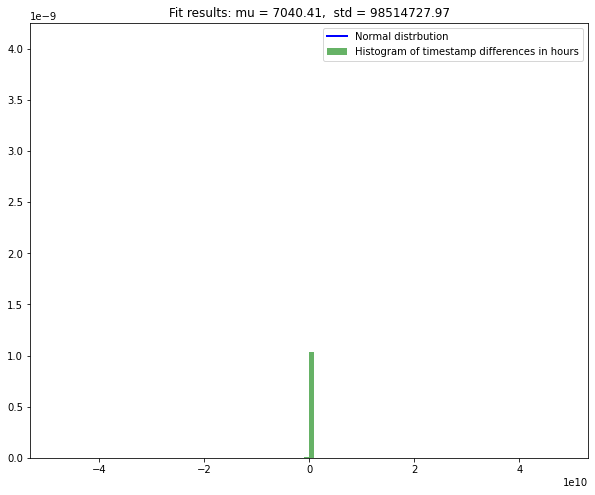

In [18]:
time_analysis(messages,'time')

## Analyze Message meta data

In [19]:
messages.describe()

,gas_fee_cap,method,time,timestampDiff
count,4.644615e+06,4.644615e+06,4.644615e+06,4.644615e+06
mean,7.670292e+09,6.318362e+00,1.622721e+18,2.534548e+07
std,8.734661e+10,1.078328e+00,7.637262e+13,3.546531e+11
min,1.000000e+02,0.000000e+00,1.622592e+18,-1.738800e+14
25%,9.399679e+06,6.000000e+00,1.622653e+18,0.000000e+00
50%,1.926023e+09,6.000000e+00,1.622722e+18,0.000000e+00
75%,5.000000e+09,7.000000e+00,1.622788e+18,0.000000e+00
max,1.170783e+14,2.300000e+01,1.622851e+18,1.738800e+14


In [20]:
messages['method'].value_counts()

6     2197377
7     2173655
5      170165
0       85902
2       10074
11       3792
4        1653
16       1402
3         337
9         136
23         58
20         28
18         17
21         14
8           4
22          1
Name: method, dtype: int64

## Required Mapping to unblock Message Analysis


* Method ID: 
    * Input for methods. What is required, what isn't.
    * Output methods. What events does the method cause
* Actor type ID:
    * Description
    * Which methods actor type can use

Data is method id crossed with actor id. We don't know what they respresent. We need to blow out to understand, this is overly flat. Need two separate keys, one for method, one for actor. 

Below is currently all we have to go on: 


https://github.com/filecoin-project/specs-actors/tree/master/actors/builtin

https://github.com/filecoin-project/specs-actors/blob/master/actors/builtin/multisig/multisig_actor.go#L52-L64

<AxesSubplot:>

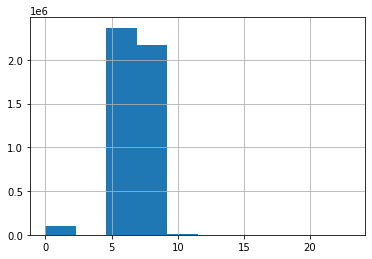

In [21]:
messages['method'].hist()

If this lookup table is correct, the vast majority of transactions are 6,7 and 5; which are RemoveSigner, SwapSigner, and AddSigner, respectively.

In [22]:
messages['from'].value_counts()

f3qcmmkbobbp6ed4psyvny6zsia5v32dlxnvpfgxsvpjtaptjyuapmd3i5zr2353fqe7a2kowceis65iyjzsoq    88709
f3vqd3cenprn6xdt73igrjukq5a7nh5rgjgajw5iev6snhv76o2sqmlgzbvq4vyje5ulrjriicsln6tz3xgimq    68142
f3ucq7fmnfoa3jsum7qjoeyz2gflwdcq4g44eiojll6lnlqe7wbx24tjvg5v4zfniwjk6cuo2l3mceq2we6kea    63760
f3sfemh6sz2zkrei23ra4fng4kjqr5tek4bleyxbrvcyndxvutmep27orixnjunm5cwqq25x4xlbup3jqbt3ua    52469
f3q2crv5dhkobq7y7fzgmfot7dtxbwe26r6wzp7ny43f5233tdzvzabdup2knjc46g6ogfi5zesn34byxhjaha    51858
                                                                                          ...  
f1sn2xg6yil5cht3pyftbgkxb7khz7bvhvozkzzri                                                     1
f14ll6y5xuhdkddzzzjnxwoeghzxj5qteykb5nsda                                                     1
f1zlba45ayd4d5gyyhw3jbw5tqpfwjbl7u25ucfrq                                                     1
f1dktxkbt4acr2cxrokxfqjnimq37jnvvrmwqkwgi                                                     1
f1rryqfsbnhhy5aour2jdp37yobty3kdvyz7niuc

In [23]:
messages['to'].value_counts()

f0755327                                     88856
f0764901                                     88802
f0688165                                     74596
f0463143                                     68439
f0724216                                     66924
                                             ...  
f1gwgrqr4jfc57e2bw2w23eujurdmh5wwlktogo7i        1
f1hmh2t7rjjbcgn6odiaa4dxvsj5poeat7eis4xiy        1
f14eijps5jbmrajtumweeo6omcufpn3m73adbcnyq        1
f1i2ccjjbqzcpz4jttepl67lzaqi4w3whqoio343i        1
f1kaf56napfppg7kdmlsztinnbpfnpnapkgodnniy        1
Name: to, Length: 37333, dtype: int64

<AxesSubplot:xlabel='timestamp'>

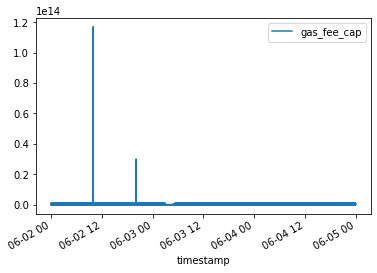

In [24]:
messages['gas_fee_cap'] = messages['gas_fee_cap'].astype(float)
messages.plot(x='timestamp',y='gas_fee_cap')

We will continue to focus on the derived_gas_outputs table with SQL queries to understand the why behind transactions as we do not have actor information easily accessible from the messages table.

## Analyze message gas economy data


In [25]:
message_gas_economy.describe()

,base_fee,base_fee_change_log,gas_capacity_ratio,gas_fill_ratio,gas_limit_total,gas_limit_unique_total,gas_waste_ratio
count,8.580000e+03,8580.000000,8580.000000,8580.000000,8.580000e+03,8.580000e+03,8580.000000
mean,1.474750e-10,0.000378,1.008772,1.966365,4.784484e+10,2.117030e+10,0.957592
std,2.446596e-10,0.386090,0.372284,0.080264,2.162609e+10,5.598819e+09,0.366611
min,1.000000e-16,-0.827117,0.257397,0.526751,3.227862e+09,3.227862e+09,0.000000
25%,9.066125e-14,-0.285272,0.733050,1.975605,2.994499e+10,1.774505e+10,0.758082
50%,1.523809e-11,-0.057982,0.941155,1.988402,4.886860e+10,2.093772e+10,1.022318
75%,2.322379e-10,0.219020,1.212218,1.994668,5.976858e+10,2.428649e+10,1.227833
max,1.961212e-09,1.000000,2.000000,2.000000,1.392380e+11,6.030551e+10,1.719983


Fourier Transform of base_fee with 10 components.


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


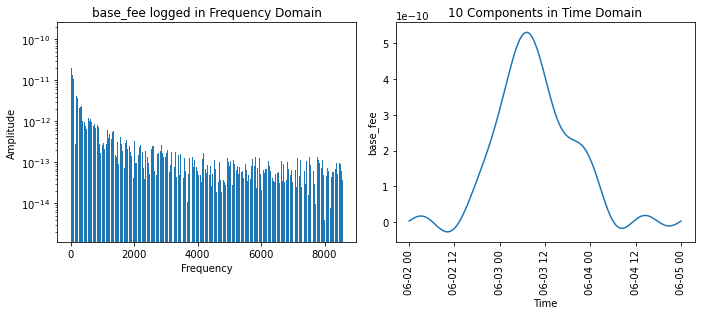

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


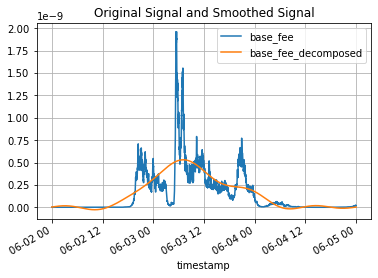

In [26]:
message_gas_economy, decomposed_base_fee = fourier_transform(message_gas_economy,'base_fee',10)

Fourier Transform of base_fee_change_log with 10 components.


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


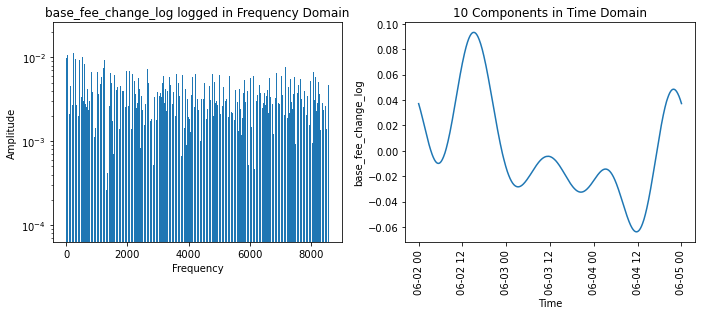

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


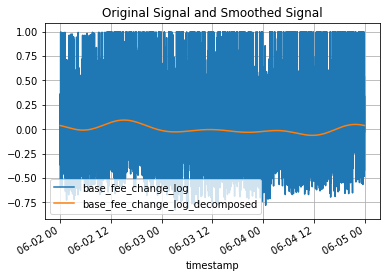

In [27]:
message_gas_economy, decomposed_base_fee_change_log = fourier_transform(message_gas_economy,'base_fee_change_log',10)

Fourier Transform of gas_capacity_ratio with 10 components.


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


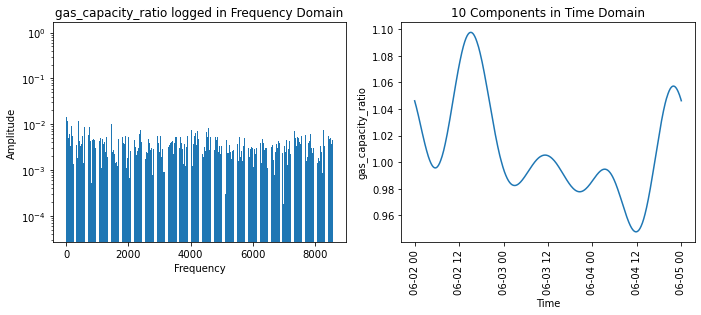

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


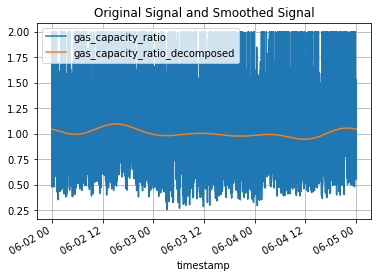

In [28]:
message_gas_economy, decomposed_gas_capacity_ratio = fourier_transform(message_gas_economy,'gas_capacity_ratio',10)

Fourier Transform of gas_fill_ratio with 10 components.


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


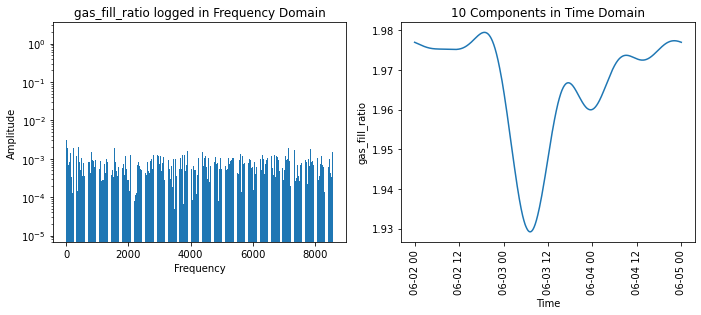

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


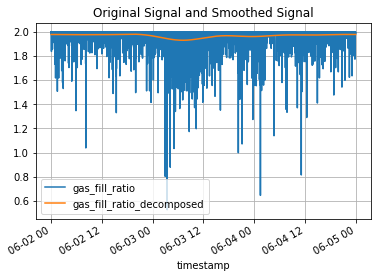

In [29]:
message_gas_economy, decomposed_gas_fill_ratio = fourier_transform(message_gas_economy,'gas_fill_ratio',10)

Fourier Transform of gas_limit_total with 10 components.


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


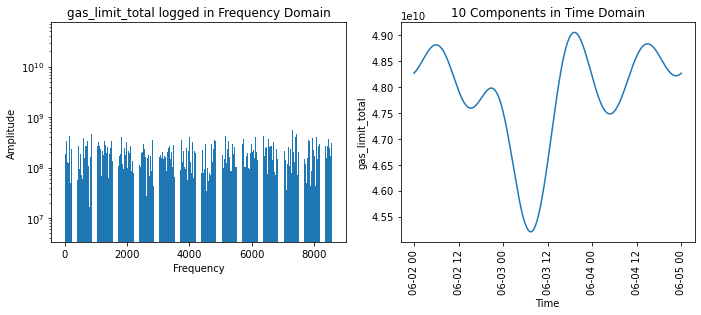

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


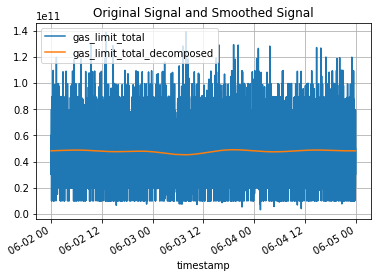

In [30]:
message_gas_economy, decomposed_gas_limit_total = fourier_transform(message_gas_economy,'gas_limit_total',10)

Fourier Transform of gas_limit_unique_total with 10 components.


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


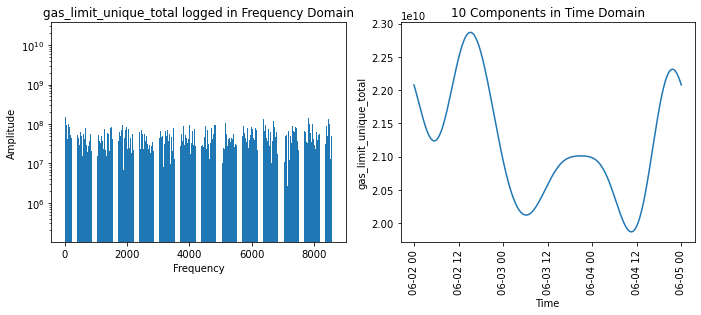

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


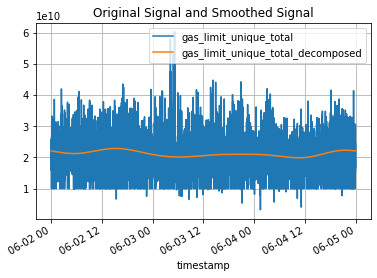

In [31]:
message_gas_economy, decomposed_gas_limit_unique_total = fourier_transform(message_gas_economy,'gas_limit_unique_total',10)

Fourier Transform of gas_waste_ratio with 10 components.


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


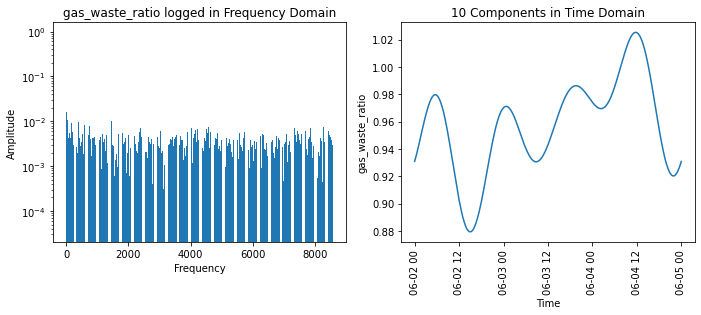

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


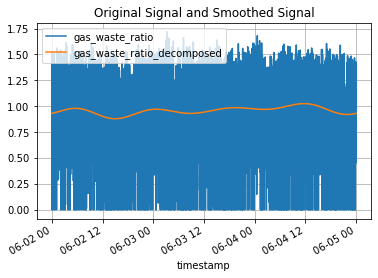

In [32]:
message_gas_economy, decomposed_gas_waste_ratio = fourier_transform(message_gas_economy,'gas_waste_ratio',10)

## Exogenous signals

https://github.com/filecoin-project/sentinel/blob/master/docs/db.md

## `chain_economics`
Economic summaries per state root CID.

|Name|Type|Nullable|Description|
|---|---|---|---|
|`burnt_fil`|`text`|NO|Total FIL (attoFIL) burned as part of penalties and on-chain computations.|
|`circulating_fil`|`text`|NO|The amount of FIL (attoFIL) circulating and tradeable in the economy. The basis for Market Cap calculations.|
|`locked_fil`|`text`|NO|The amount of FIL (attoFIL) locked as part of mining, deals, and other mechanisms.|
|`mined_fil`|`text`|NO|The amount of FIL (attoFIL) that has been mined by storage miners.|
|`parent_state_root`|`text`|NO|CID of the parent state root.|
|`vested_fil`|`text`|NO|Total amount of FIL (attoFIL) that is vested from genesis allocation.|


## `chain_powers`
Power summaries from the Power actor.

|Name|Type|Nullable|Description|
|---|---|---|---|
|`height`|`bigint`|NO|Epoch this power summary applies to.|
|`miner_count`|`bigint`|YES|Total number of miners.|
|`participating_miner_count`|`bigint`|YES|Total number of miners with power above the minimum miner threshold.|
|`qa_smoothed_position_estimate`|`text`|NO|Total power smoothed position estimate - Alpha Beta Filter "position" (value) estimate in Q.128 format.|
|`qa_smoothed_velocity_estimate`|`text`|NO|Total power smoothed velocity estimate - Alpha Beta Filter "velocity" (rate of change of value) estimate in Q.128 format.|
|`state_root`|`text`|NO|CID of the parent state root.|
|`total_pledge_collateral`|`text`|NO|Total locked FIL (attoFIL) miners have pledged as collateral in order to participate in the economy.|
|`total_qa_bytes_committed`|`text`|NO|Total provably committed, quality adjusted storage power in bytes. Quality adjusted power is a weighted average of the quality of its space and it is based on the size, duration and quality of its deals.|
|`total_qa_bytes_power`|`text`|NO|Total quality adjusted storage power in bytes in the network. Quality adjusted power is a weighted average of the quality of its space and it is based on the size, duration and quality of its deals.|
|`total_raw_bytes_committed`|`text`|NO|Total provably committed storage power in bytes. Raw byte power is the size of a sector in bytes.|
|`total_raw_bytes_power`|`text`|NO|Total storage power in bytes in the network. Raw byte power is the size of a sector in bytes.|


## `chain_rewards`
Reward summaries from the Reward actor.

|Name|Type|Nullable|Description|
|---|---|---|---|
|`cum_sum_baseline`|`text`|NO|Target that CumsumRealized needs to reach for EffectiveNetworkTime to increase. It is measured in byte-epochs (space * time) representing power committed to the network for some duration.|
|`cum_sum_realized`|`text`|NO|Cumulative sum of network power capped by BaselinePower(epoch). It is measured in byte-epochs (space * time) representing power committed to the network for some duration.|
|`effective_baseline_power`|`text`|NO|The baseline power (in bytes) at the EffectiveNetworkTime epoch.|
|`effective_network_time`|`bigint`|YES|Ceiling of real effective network time "theta" based on CumsumBaselinePower(theta) == CumsumRealizedPower. Theta captures the notion of how much the network has progressed in its baseline and in advancing network time.|
|`height`|`bigint`|NO|Epoch this rewards summary applies to.|
|`new_baseline_power`|`text`|NO|The baseline power (in bytes) the network is targeting.|
|`new_reward`|`text`|YES|The reward to be paid in per WinCount to block producers. The actual reward total paid out depends on the number of winners in any round. This value is recomputed every non-null epoch and used in the next non-null epoch.|
|`new_reward_smoothed_position_estimate`|`text`|NO|Smoothed reward position estimate - Alpha Beta Filter "position" (value) estimate in Q.128 format.|
|`new_reward_smoothed_velocity_estimate`|`text`|NO|Smoothed reward velocity estimate - Alpha Beta Filter "velocity" (rate of change of value) estimate in Q.128 format.|
|`state_root`|`text`|NO|CID of the parent state root.|
|`total_mined_reward`|`text`|NO|The total FIL (attoFIL) awarded to block miners.|

In [40]:
QUERY = """
SELECT 
to_timestamp(height_to_unix(cr.height)) as timestamp,
cr.cum_sum_baseline,
cr.cum_sum_realized,
cr.effective_baseline_power,
cr.effective_network_time,
cr.new_baseline_power,
cr.new_reward,
cr.new_reward_smoothed_position_estimate,
cr.new_reward_smoothed_velocity_estimate,
cr.total_mined_reward,
cp.miner_count,
cp.participating_miner_count,
cp.qa_smoothed_position_estimate,
cp.qa_smoothed_velocity_estimate,
cp.state_root,
cp.total_pledge_collateral,
cp.total_qa_bytes_committed,
cp.total_qa_bytes_power,
cp.total_raw_bytes_committed,
cp.total_raw_bytes_power,
ce.burnt_fil,
ce.circulating_fil,
ce.locked_fil,
ce.mined_fil,
ce.vested_fil
FROM chain_rewards cr
LEFT JOIN chain_powers cp
ON cr.state_root = cp.state_root
LEFT JOIN chain_economics ce
ON cr.state_root = ce.parent_state_root
WHERE
to_timestamp(height_to_unix(cr.height)) BETWEEN '2021-06-01' AND '2021-07-01'
"""
chain_economics = (pd.read_sql(QUERY, connection))


In [43]:
chain_economics[['cum_sum_baseline', 'cum_sum_realized',
       'effective_baseline_power', 'effective_network_time',
       'new_baseline_power','new_reward_smoothed_position_estimate',
       'new_reward_smoothed_velocity_estimate', 'total_mined_reward',
       'miner_count', 'participating_miner_count',
       'qa_smoothed_position_estimate','qa_smoothed_velocity_estimate','total_pledge_collateral', 'total_qa_bytes_committed',
       'total_qa_bytes_power', 'total_raw_bytes_committed',
       'total_raw_bytes_power', 'burnt_fil', 'circulating_fil', 'locked_fil',
       'mined_fil', 'vested_fil']] = chain_economics[['cum_sum_baseline', 'cum_sum_realized',
       'effective_baseline_power', 'effective_network_time',
       'new_baseline_power','new_reward_smoothed_position_estimate',
       'new_reward_smoothed_velocity_estimate', 'total_mined_reward',
       'miner_count', 'participating_miner_count',
       'qa_smoothed_position_estimate','qa_smoothed_velocity_estimate', 'total_pledge_collateral', 'total_qa_bytes_committed',
       'total_qa_bytes_power', 'total_raw_bytes_committed',
       'total_raw_bytes_power', 'burnt_fil', 'circulating_fil', 'locked_fil',
       'mined_fil', 'vested_fil']].astype(float)

In [44]:
chain_economics.describe()

,cum_sum_baseline,cum_sum_realized,effective_baseline_power,effective_network_time,new_baseline_power,new_reward,new_reward_smoothed_position_estimate,new_reward_smoothed_velocity_estimate,total_mined_reward,miner_count,...,total_pledge_collateral,total_qa_bytes_committed,total_qa_bytes_power,total_raw_bytes_committed,total_raw_bytes_power,burnt_fil,circulating_fil,locked_fil,mined_fil,vested_fil
count,8.525900e+04,8.525900e+04,8.525900e+04,85259.000000,8.525900e+04,8.525900e+04,8.525900e+04,8.525900e+04,8.525900e+04,85259.000000,...,8.525900e+04,8.525900e+04,8.525900e+04,8.525900e+04,8.525900e+04,8.525900e+04,8.525900e+04,8.525900e+04,8.525900e+04,8.525900e+04
mean,2.117221e+24,2.117219e+24,4.284956e+18,597601.800772,5.059368e+18,1.264016e+20,4.301223e+58,-9.164505e+51,7.589834e+25,541555.566146,...,8.272870e+25,7.396019e+18,7.395577e+18,7.393683e+18,7.393252e+18,2.646491e+25,1.350217e+26,8.273785e+25,7.589834e+25,1.512595e+26
std,1.258826e+23,1.258826e+23,8.300527e+16,29376.941196,8.300524e+16,6.686428e+17,2.275268e+56,1.384736e+50,3.085544e+24,468.881553,...,2.469818e+24,3.621160e+17,3.621347e+17,3.619564e+17,3.619715e+17,2.952578e+23,3.479301e+24,2.470447e+24,3.085544e+24,3.153654e+24
min,1.901761e+24,1.901758e+24,4.142884e+18,546751.000000,4.917297e+18,1.252452e+20,4.261871e+58,-9.407656e+51,7.054874e+25,541144.000000,...,7.830897e+25,6.721132e+18,6.720618e+18,6.719005e+18,6.718506e+18,2.604027e+25,1.290679e+26,7.831719e+25,7.054874e+25,1.458100e+26
25%,2.008047e+24,2.008046e+24,4.212968e+18,572191.500000,4.987381e+18,1.258254e+20,4.281616e+58,-9.283836e+51,7.322973e+25,541366.000000,...,8.061695e+25,7.109558e+18,7.109093e+18,7.107348e+18,7.106899e+18,2.613655e+25,1.320648e+26,8.062548e+25,7.322973e+25,1.485305e+26
50%,2.115896e+24,2.115894e+24,4.284082e+18,597577.000000,5.058495e+18,1.263982e+20,4.301104e+58,-9.162910e+51,7.589920e+25,541488.000000,...,8.279218e+25,7.407435e+18,7.407039e+18,7.405115e+18,7.404737e+18,2.647754e+25,1.349388e+26,8.280132e+25,7.589920e+25,1.512521e+26
75%,2.225168e+24,2.225168e+24,4.356134e+18,622871.500000,5.130548e+18,1.269790e+20,4.320868e+58,-9.044957e+51,7.855009e+25,541575.000000,...,8.486375e+25,7.703864e+18,7.703419e+18,7.701365e+18,7.700921e+18,2.676042e+25,1.379530e+26,8.487347e+25,7.855009e+25,1.539710e+26
max,2.338950e+24,2.338948e+24,4.431161e+18,648769.000000,5.205574e+18,1.275672e+20,4.340886e+58,-8.926758e+51,8.125866e+25,544363.000000,...,8.679158e+25,7.992995e+18,7.992564e+18,7.990300e+18,7.989885e+18,2.685054e+25,1.414348e+26,8.680170e+25,8.125866e+25,1.567617e+26


## Signal Analysis

In [45]:
chain_economics.fillna(0,inplace=True)

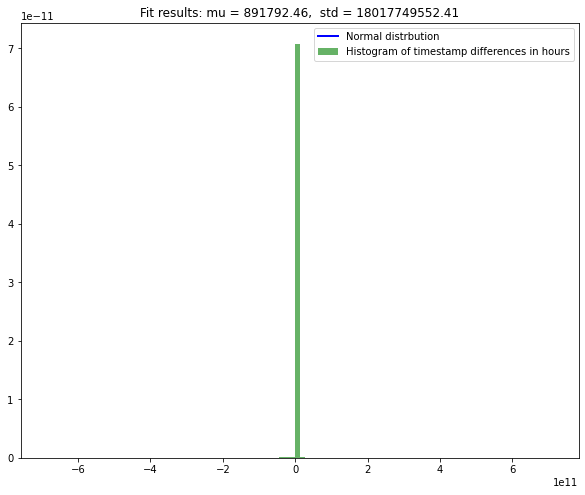

In [46]:
chain_economics['time'] = chain_economics['timestamp'].apply(lambda x: x.value)

time_analysis(chain_economics,'time')

## VAR Analysis

array([[<AxesSubplot:title={'center':'cum_sum_baseline'}>,
        <AxesSubplot:title={'center':'cum_sum_realized'}>,
        <AxesSubplot:title={'center':'effective_baseline_power'}>,
        <AxesSubplot:title={'center':'effective_network_time'}>,
        <AxesSubplot:title={'center':'new_baseline_power'}>],
       [<AxesSubplot:title={'center':'new_reward'}>,
        <AxesSubplot:title={'center':'new_reward_smoothed_position_estimate'}>,
        <AxesSubplot:title={'center':'new_reward_smoothed_velocity_estimate'}>,
        <AxesSubplot:title={'center':'total_mined_reward'}>,
        <AxesSubplot:title={'center':'miner_count'}>],
       [<AxesSubplot:title={'center':'participating_miner_count'}>,
        <AxesSubplot:title={'center':'qa_smoothed_position_estimate'}>,
        <AxesSubplot:title={'center':'qa_smoothed_velocity_estimate'}>,
        <AxesSubplot:title={'center':'total_pledge_collateral'}>,
        <AxesSubplot:title={'center':'total_qa_bytes_committed'}>],
       [<Axes

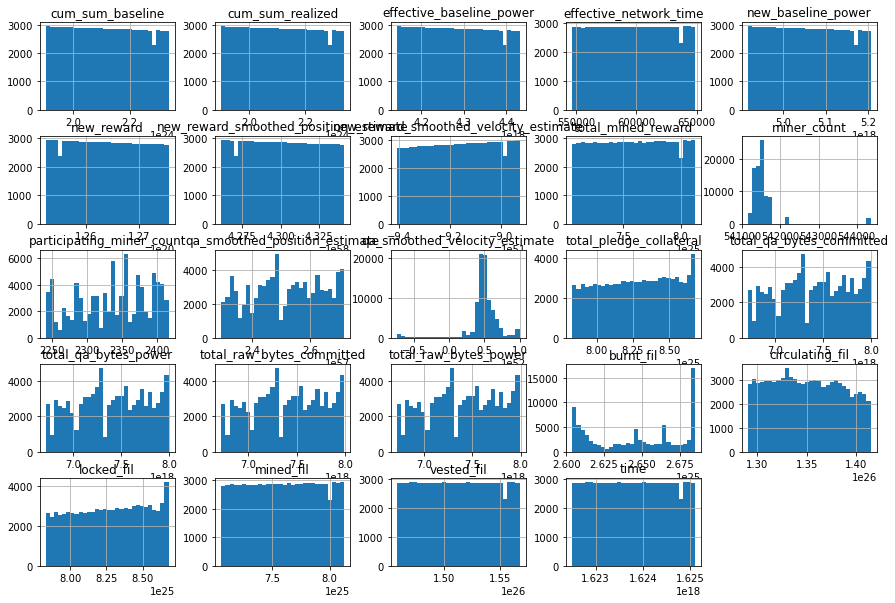

In [48]:
timestamps = chain_economics.timestamp.values
del chain_economics['timestamp']
del chain_economics['state_root']
del chain_economics['timestampDiff']
chain_economics.hist(bins=30, figsize=(15, 10))

In [49]:
# normally distribute
log_differenced = pd.DataFrame()
## Difference and log values
for i in chain_economics.columns:
    try:
        log_differenced[i +'_log_differenced'] = np.log(chain_economics[i]).diff()
    except:
        print('Error with:{}'.format(i))

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [50]:
# replace any NA values with zero
log_differenced.fillna(0,inplace=True)

array([[<AxesSubplot:title={'center':'cum_sum_baseline_log_differenced'}>,
        <AxesSubplot:title={'center':'cum_sum_realized_log_differenced'}>,
        <AxesSubplot:title={'center':'effective_baseline_power_log_differenced'}>,
        <AxesSubplot:title={'center':'effective_network_time_log_differenced'}>,
        <AxesSubplot:title={'center':'new_baseline_power_log_differenced'}>],
       [<AxesSubplot:title={'center':'new_reward_log_differenced'}>,
        <AxesSubplot:title={'center':'new_reward_smoothed_position_estimate_log_differenced'}>,
        <AxesSubplot:title={'center':'new_reward_smoothed_velocity_estimate_log_differenced'}>,
        <AxesSubplot:title={'center':'total_mined_reward_log_differenced'}>,
        <AxesSubplot:title={'center':'miner_count_log_differenced'}>],
       [<AxesSubplot:title={'center':'participating_miner_count_log_differenced'}>,
        <AxesSubplot:title={'center':'qa_smoothed_position_estimate_log_differenced'}>,
        <AxesSubplot:title=

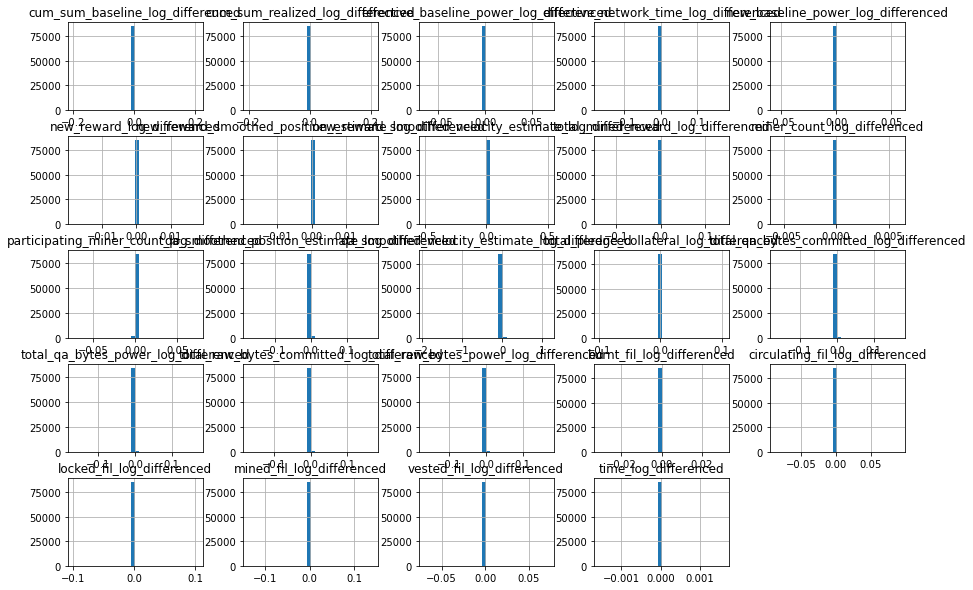

In [52]:
log_differenced.hist(bins=30, figsize=(15, 10))

As a final check prior to modeling, we will run the Augmented Dickey-Fuller test to ensure that our data is stationary (non-unit root - A unit root is a stochastic trend in a time series). The test's hypothesis are:


* $H_O: \textrm{Time series has a unit root}$
* $H_A: \textrm{Time series does not have a unit root}$

In [53]:
for i in log_differenced.columns:
    print(i)
    result = adfuller(log_differenced[i].values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] > 0.05:
        decision = "fail to reject - unit root present"
    else:
        decision = "reject, no unit root present"
    print(decision)
    print('----------------------------------')

cum_sum_baseline_log_differenced
ADF Statistic: -42.639311
p-value: 0.000000
reject, no unit root present
----------------------------------
cum_sum_realized_log_differenced
ADF Statistic: -42.639312
p-value: 0.000000
reject, no unit root present
----------------------------------
effective_baseline_power_log_differenced
ADF Statistic: -42.780300
p-value: 0.000000
reject, no unit root present
----------------------------------
effective_network_time_log_differenced
ADF Statistic: -42.607162
p-value: 0.000000
reject, no unit root present
----------------------------------
new_baseline_power_log_differenced
ADF Statistic: -42.790625
p-value: 0.000000
reject, no unit root present
----------------------------------
new_reward_log_differenced
ADF Statistic: -42.756446
p-value: 0.000000
reject, no unit root present
----------------------------------
new_reward_smoothed_position_estimate_log_differenced
ADF Statistic: -42.756452
p-value: 0.000000
reject, no unit root present
-----------------

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


ADF Statistic: nan
p-value: nan
reject, no unit root present
----------------------------------
total_mined_reward_log_differenced
ADF Statistic: -42.621606
p-value: 0.000000
reject, no unit root present
----------------------------------
miner_count_log_differenced
ADF Statistic: -43.946720
p-value: 0.000000
reject, no unit root present
----------------------------------
participating_miner_count_log_differenced
ADF Statistic: -41.758417
p-value: 0.000000
reject, no unit root present
----------------------------------
qa_smoothed_position_estimate_log_differenced
ADF Statistic: -41.999376
p-value: 0.000000
reject, no unit root present
----------------------------------
qa_smoothed_velocity_estimate_log_differenced
ADF Statistic: -29.045668
p-value: 0.000000
reject, no unit root present
----------------------------------
total_pledge_collateral_log_differenced
ADF Statistic: -42.447073
p-value: 0.000000
reject, no unit root present
----------------------------------
total_qa_bytes_comm

In [54]:
# removed several columns because of VAR errors
log_differenced_subset = log_differenced[['cum_sum_baseline_log_differenced', 'cum_sum_realized_log_differenced',
                                       'effective_baseline_power_log_differenced','effective_network_time_log_differenced',
                                       'new_baseline_power_log_differenced','total_mined_reward_log_differenced',
                                       'miner_count_log_differenced','participating_miner_count_log_differenced',
                                       'qa_smoothed_position_estimate_log_differenced','qa_smoothed_velocity_estimate_log_differenced',
                                       'total_pledge_collateral_log_differenced','total_qa_bytes_committed_log_differenced',
                                       'total_qa_bytes_power_log_differenced','total_raw_bytes_committed_log_differenced',
                                       'total_raw_bytes_power_log_differenced','burnt_fil_log_differenced','circulating_fil_log_differenced',
                                       'locked_fil_log_differenced','vested_fil_log_differenced']]

In [55]:
# var model
aic = []
for i in range(1,16):
    model = VAR(log_differenced_subset)
    results = model.fit(i)
    aic.append(results.aic)

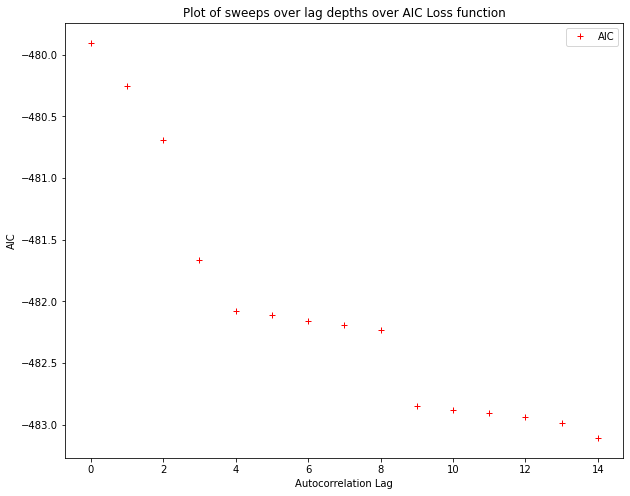

In [56]:
plt.figure(figsize=(10, 8))
plt.plot(aic, 'r+')
plt.legend(['AIC'])
plt.xlabel('Autocorrelation Lag')
plt.ylabel('AIC')
plt.title('Plot of sweeps over lag depths over AIC Loss function')
plt.show()

In [57]:
# instantiate the var model object from statsmodels
model = VAR(log_differenced_subset)

# fit model with determined lag values
results = model.fit(4)

In [58]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 08, Aug, 2021
Time:                     16:02:09
--------------------------------------------------------------------
No. of Equations:         19.0000    BIC:                   -481.506
Nobs:                     85255.0    HQIC:                  -481.617
Log likelihood:       1.82352e+07    FPE:               6.53208e-210
AIC:                     -481.666    Det(Omega_mle):    6.42853e-210
--------------------------------------------------------------------
Results for equation cum_sum_baseline_log_differenced
                                                      coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------------------------
const                                                    0.000000         0.000017            0.016           0.987
L1.cum_su

In [59]:
alpha = 0.05
result_dfs = []
variables = list(log_differenced_subset.columns)
for i in variables:
    for j in variables:
        if i==j:
            pass
        else:
            results_summary = results.test_causality(i,j, 
                                                     kind='f',signif=alpha).summary()


            df = pd.read_html(results_summary.as_html(),header=0, index_col=0)[0]
            df['alpha'] = alpha
            df['caused'] = i
            df['causing'] = j
            result_dfs.append(df)
        
Grangers_df = pd.concat(result_dfs)
Grangers_df.reset_index(inplace=True)
Grangers_df['result'] = Grangers_df['p-value'].apply(lambda x: 'reject H0' if x < alpha else 'fail to reject H0' )
Grangers_df




,Test statistic,Critical value,p-value,df,alpha,caused,causing,result
0,0.02929,2.372,0.998,"(4, 1618382)",0.05,cum_sum_baseline_log_differenced,cum_sum_realized_log_differenced,fail to reject H0
1,16.03000,2.372,0.000,"(4, 1618382)",0.05,cum_sum_baseline_log_differenced,effective_baseline_power_log_differenced,reject H0
2,10.85000,2.372,0.000,"(4, 1618382)",0.05,cum_sum_baseline_log_differenced,effective_network_time_log_differenced,reject H0
3,0.02848,2.372,0.998,"(4, 1618382)",0.05,cum_sum_baseline_log_differenced,new_baseline_power_log_differenced,fail to reject H0
4,13.92000,2.372,0.000,"(4, 1618382)",0.05,cum_sum_baseline_log_differenced,total_mined_reward_log_differenced,reject H0
...,...,...,...,...,...,...,...,...
337,13.99000,2.372,0.000,"(4, 1618382)",0.05,vested_fil_log_differenced,total_raw_bytes_committed_log_differenced,reject H0
338,10.45000,2.372,0.000,"(4, 1618382)",0.05,vested_fil_log_differenced,total_raw_bytes_power_log_differenced,reject H0
339,13.16000,2.372,0.000,"(4, 1618382)",0.05,vested_fil_log_differenced,burnt_fil_log_differenced,reject H0
340,13.33000,2.372,0.000,"(4, 1618382)",0.05,vested_fil_log_differenced,circulating_fil_log_differenced,reject H0


Text(0.5, 0.98, 'Heatmap of Granger Casuality \n Green shows causal relationship whereas red shows no causal relationship')

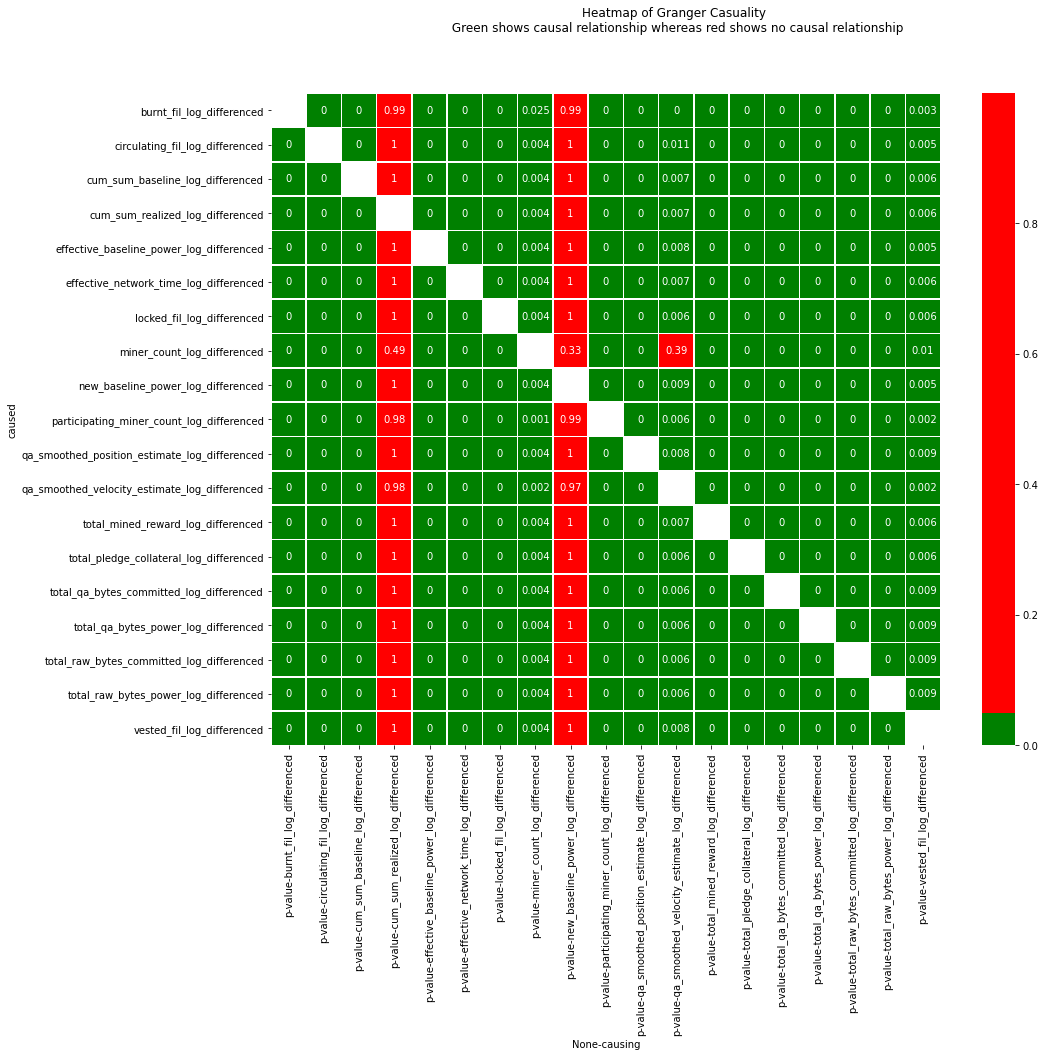

In [60]:
heatdf = Grangers_df.pivot(index='caused', columns=['causing'],values=['p-value'])

f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(heatdf, annot=True, linewidths=.5, ax=ax,cmap=['green','red'],center=0.05)
plt.suptitle('Heatmap of Granger Casuality \n Green shows causal relationship whereas red shows no causal relationship')




In [61]:
Grangers_df.query("result == 'reject H0'").sort_values('p-value',ascending=True)

,Test statistic,Critical value,p-value,df,alpha,caused,causing,result
1,16.030,2.372,0.000,"(4, 1618382)",0.05,cum_sum_baseline_log_differenced,effective_baseline_power_log_differenced,reject H0
205,22.300,2.372,0.000,"(4, 1618382)",0.05,total_qa_bytes_committed_log_differenced,participating_miner_count_log_differenced,reject H0
206,15.170,2.372,0.000,"(4, 1618382)",0.05,total_qa_bytes_committed_log_differenced,qa_smoothed_position_estimate_log_differenced,reject H0
208,15.700,2.372,0.000,"(4, 1618382)",0.05,total_qa_bytes_committed_log_differenced,total_pledge_collateral_log_differenced,reject H0
209,9.018,2.372,0.000,"(4, 1618382)",0.05,total_qa_bytes_committed_log_differenced,total_qa_bytes_power_log_differenced,reject H0
...,...,...,...,...,...,...,...,...
233,3.398,2.372,0.009,"(4, 1618382)",0.05,total_qa_bytes_power_log_differenced,vested_fil_log_differenced,reject H0
80,3.411,2.372,0.009,"(4, 1618382)",0.05,new_baseline_power_log_differenced,qa_smoothed_velocity_estimate_log_differenced,reject H0
125,3.345,2.372,0.010,"(4, 1618382)",0.05,miner_count_log_differenced,vested_fil_log_differenced,reject H0
297,3.262,2.372,0.011,"(4, 1618382)",0.05,circulating_fil_log_differenced,qa_smoothed_velocity_estimate_log_differenced,reject H0
